## Initialization

In [1]:
import pixiedust
pixiedust.enableJobMonitor()

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully


Pixiedust runtime updated. Please restart kernel
Table SPARK_PACKAGES created successfully
Table USER_PREFERENCES created successfully
Table service_connections created successfully


Succesfully enabled Spark Job Progress Monitor


## import packages

In [2]:
from random import random

from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType, IntegerType, FloatType
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/site-packages/pixiedust/utils/sparkJobProgressMonitor.py", line 47, in startSparkJobProgressMonitor
    progressMonitor = SparkJobProgressMonitor()
  File "/opt/conda/lib/python3.6/site-packages/pixiedust/utils/sparkJobProgressMonitor.py", line 174, in __init__
    self.addSparkListener()
  File "/opt/conda/lib/python3.6/site-packages/pixiedust/utils/sparkJobProgressMonitor.py", line 203, in addSparkListener
    _env.getTemplate("sparkJobProgressMonitor/addSparkListener.scala").render()
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2131, in run_cell_magic
    result = fn(magic_arg_s, cell)
  File "<decorator-gen-126>", line 2, in scala
  File "/opt/

## Read Data and Cleaning
First examine how many lines does it contain

In [3]:
rdd = sc.textFile('../Project/Data/Broilers_Data.txt')
"""
We use tab delimited file (converted by Excel)
since it's not easy to distinguish between the comma inside numbers 
and the comma used as delimited symbol in csv file.
"""
lineSpliter = rdd.map(lambda x: x.split('\t'))
print("The file has {0} lines\n".format(lineSpliter.count()))

The file has 3678 lines



### Change the header of the columns

That is to make it more readable and remove all space inside column names as well.

In [4]:
header = ['Main_Key', 'Date', 'Customer_Code', 'House', 'Flock', 'Gene_Line', 'Birds_Begin', 'Hatch_Date', 'Arrive_Date',\
 'Remove_date', 'Deactivate_Date', 'Veterinarian', 'Hatchery', 'Age', 'Birds_Present', 'Birds_thinned', 'Death',\
 'Death_Cum', 'Total_Death_Rate', 'Alive_Rate', 'Body_Weight_g', 'Uniformity_Rate', 'Daily_Gaing', 'Avg_Daily_Gaing_Per_Day',\
 'Feed_Intake_Per_house_kg', 'FCR_Cum', 'Wheat_Per_Bird_Cum', 'Wheat_Per_Bird', 'Wheat_Per_Day',\
 'Feed_Intake_Per_Bird_Housed_Cum_kg', 'Feed_Intake_Per_Bird_g', 'Wheat_g', 'FCR', 'Water_l', 'Water_Intake_Per_Bird_ml',\
 'Water_Intake_Per_Bird_Cum_l', 'Water_Feed', 'Water_FeedCum', 'Comment']

# If needed:
# print("The header of this file is \n{0}\n".format(header))
# print("The header of this file has {0} lines".format(len(header)))

Inspect how many lines does it contain, as well as the length disturbution(of lines).

In [5]:
data = lineSpliter.filter(lambda x: x[0] != "Date")
print("Data in this file has {0} lines".format(data.count()))

def lengthInspector(rdd):
    lenCounter = rdd.map(lambda x: (len(x), 1))\
                 .reduceByKey(lambda x, y: x + y)
    lenList = lenCounter.collect()
    return lenList
lenList = lengthInspector(data)
print("Distribution of length of lines in this file: ")
print(lenList)

Data in this file has 3677 lines
Distribution of length of lines in this file: 
[(38, 3676), (1, 1)]


### Build main key and do some cleaning

In [8]:
def buildMainKey(line):
    mainKey = "Farm " + line[1].strip() + " House " + line[2].strip() + " Flock " + line[3].strip()
    newline = [mainKey] + line
    return newline

emptyClener = data.filter(lambda x: len(x) >= 38)
print("Not empty data has {0} lines".format(emptyClener.count()))

mainKeyCounter = emptyClener.map(lambda x: buildMainKey(x))\
                            .map(lambda x: (x[0], 1))\
                            .reduceByKey(lambda x, y: x + y)
print("\nThere are {0} different main keys".format(mainKeyCounter.count()))

Not empty data has 3676 lines

There are 76 different main keys


#### Print out all the main keys so that we can clean up the invaild ones

In [7]:
for key in mainKeyCounter.collect():
    print(key)

('Farm A House 1 Flock 2016-07', 138)
('Farm A House 1 Flock 2016-10', 41)
('Farm B House 3 Flock 2016-11', 50)
('Farm B House 1 Flock 2016-11', 50)
('Farm B House 3 Flock 2016-12', 46)
('Farm B House 2 Flock 2017-01', 39)
('Farm B House 2 Flock 17-3', 25)
('Farm B House 1 Flock 17-3', 25)
('Farm B House 2 Flock ', 1)
('Farm B House 3 Flock ', 1)
('Farm B House 1 Flock ', 1)
('Farm C House 2 Flock Koppel 11 stal 2', 58)
('Farm D House 1 Flock 2016-07', 64)
('Farm D House 3 Flock 2016-07', 64)
('Farm D House 2 Flock 2016-09', 46)
('Farm D House 2 Flock 2016-11', 45)
('Farm D House 3 Flock 2016-12', 46)
('Farm D House 1 Flock 2016-12', 46)
('Farm D House 2 Flock 2017-02', 52)
('Farm D House 3 Flock 2017-04', 43)
('Farm D House 2 Flock 2017-06', 50)
('Farm D House 3 Flock 2017-06', 50)
('Farm D House 1 Flock 2017-10', 28)
('Farm D House 3 Flock 2017-10', 28)
('Farm E House 5 Flock 2016-09', 54)
('Farm E House 6 Flock 2016-11', 53)
('Farm E House 8 Flock 2016-11', 51)
('Farm E House 7 Floc

#### Clean up invaild main keys
And print our how many lines left

In [9]:
errorMainKeyCleaner = emptyClener.filter(lambda x: False if x[3] == "" else True)
print("There are {0} lines with vaild main key".format(errorMainKeyCleaner.count()))

cleanData = errorMainKeyCleaner.map(lambda x: buildMainKey(x))
cleanMainKeyCounter = cleanData.map(lambda x: (x[0], 1))\
                               .reduceByKey(lambda x, y: x + y)
mainKeysWithCounts = cleanMainKeyCounter.collect()
mainKeys = cleanMainKeyCounter.map(lambda x: x[0]).collect()

There are 3673 lines with vaild main key


#### Adjust the format for float numbers in our data

In [10]:
def reduceDot(linex, liney):
    new_list = []
    for i in range(len(linex)):
        new_list.append(linex[i] or liney[i])
    return new_list

checkAllDot = cleanData.map(lambda x: [('.' in i) for i in x])\
                       .reduce(lambda x, y: reduceDot(x, y))
print(checkAllDot)

def numberCleaner(line):
    """
    This function needs to be improved
    """
    resultList = []
    item = None
    for idx in range(len(line)):
        if idx <= 12 or idx == 38:
            if idx == 6: 
                if not line[idx]: item = -1
                else:
                    item = line[idx].strip().replace(',', '').replace(' ', '')
                    item = int(item)
            else: 
                if not line[idx]: item = ""
                else: item = line[idx]
        elif checkAllDot[idx]:
            if not line[idx]: item = -0.1
            else:
                item = line[idx].strip().replace(',', '').replace(' ', '')
                item = float(item)
        else: 
            if not line[idx]: item = -1
            else:
                item = line[idx].strip().replace(',', '').replace(' ', '').replace('"', '')
                item = int(item)
        resultList.append(item)
    return resultList

numCleanData = cleanData.map(numberCleaner)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


#### Clean up all negative and empty values
Then we will get two useful data sets (one in RDD, the other in Dataframe)

In [11]:
def transferNone(line):
    new_line = []
    for item in line:
        if type(item) != str:
            if item < 0: new_line.append(None)
            else: new_line.append(item)
        else:
            if not item: new_line.append(None)
            else:new_line.append(item)
    return new_line

broilers = numCleanData.map(transferNone)

broilersDF = sqlContext.createDataFrame(numCleanData, header)

## Preparation for analyse
### First Build the function to run linear regression

In [14]:
def Do_Linear_Regression(DataSet, xCols, yValue, evalMetric = "rmse", seed = None):
    """
    Return (<object> model, <float> error_estimate, <dataframe> result)
    
    trainingSet: dataframe, used to train model
    testSet: dataframe, used to feed the model and get the result(and error estimate)
    xCols: list of strings, names of columns which used as inputs
    yValue: string, name of column that contains dependent values 
    regressor: Regression object, by default = LinearRegression()
    paramGrid: list built byParamGridBuilder, by default = empty list
    evalMetric: string, name of matrix used for evaluation, by default = "rmse"
    seed: int or None, seed for random number generator, if == None will use random numbers
    """
    if not seed:
        (trainingSet, testSet) = DataSet.randomSplit([0.2, 0.8])
    else: (trainingSet, testSet) = DataSet.randomSplit([0.2, 0.8], seed)
        
    regressor = LinearRegression()
    regressor.setPredictionCol("Predicted")\
             .setLabelCol(yValue)
    
    regParam = [x / 100.0 for x in range(1, 10)]
    paramGrid = (ParamGridBuilder()
                 .addGrid(regressor.regParam, regParam)
                 .build())
    
    # push estimator into pipeline
    vec = VectorAssembler(inputCols = xCols, outputCol = "features")
    regPipeline = Pipeline()
    regPipeline.setStages([vec, regressor])   
    # build evaluator
    regEval = RegressionEvaluator(predictionCol = "Predicted", labelCol = yValue, metricName = evalMetric)
    # combine estimator and evaluator to a cross validator
    crossval = CrossValidator(estimator = regPipeline, evaluator = regEval, numFolds = 3)
    # set parameters grid
    crossval.setEstimatorParamMaps(paramGrid)
    # trainning
    regModel = crossval.fit(trainingSet).bestModel
    # predicting
    predictions = regModel.transform(testSet)
    # get evaluating result
    evaluation = regEval.evaluate(predictions)
    nDF = broilersDF.withColumn("NewCol", broilersDF.Main_Key + 'a')
    return regModel, evaluation, predictions

In [15]:
print(mainKeys)
print(header)
# Have a look on the names of rows and columns

['Farm A House 1 Flock 2016-07', 'Farm A House 1 Flock 2016-10', 'Farm B House 3 Flock 2016-11', 'Farm B House 1 Flock 2016-11', 'Farm B House 3 Flock 2016-12', 'Farm B House 2 Flock 2017-01', 'Farm B House 2 Flock 17-3', 'Farm B House 1 Flock 17-3', 'Farm C House 2 Flock Koppel 11 stal 2', 'Farm D House 1 Flock 2016-07', 'Farm D House 3 Flock 2016-07', 'Farm D House 2 Flock 2016-09', 'Farm D House 2 Flock 2016-11', 'Farm D House 3 Flock 2016-12', 'Farm D House 1 Flock 2016-12', 'Farm D House 2 Flock 2017-02', 'Farm D House 3 Flock 2017-04', 'Farm D House 2 Flock 2017-06', 'Farm D House 3 Flock 2017-06', 'Farm D House 1 Flock 2017-10', 'Farm D House 3 Flock 2017-10', 'Farm E House 5 Flock 2016-09', 'Farm E House 6 Flock 2016-11', 'Farm E House 8 Flock 2016-11', 'Farm E House 7 Flock 2017-01', 'Farm E House 8 Flock 2017-01', 'Farm E House 8 Flock 2017-04', 'Farm E House 7 Flock 2017-04', 'Farm E House 7 Flock 2017-07', 'Farm E House 8 Flock 2017-07', 'Farm E House 6 Flock 2017-07', 'Far

### Print graphs to determine values used to clean data

( Age vs. Feed Intake, Age vs. Water Intake and Age vs. body weight )


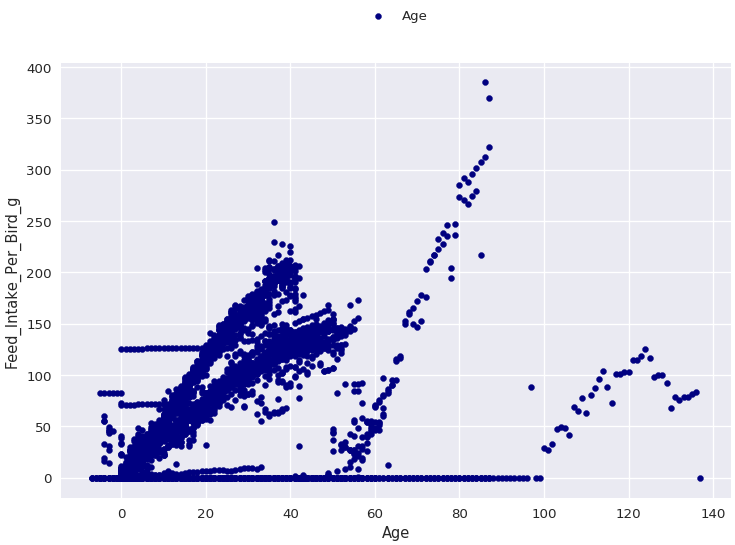

In [16]:
display(broilersDF)

#### The idea is that we can use these graphs to filter out evident extreme values
However, some patterns of error can be clearly saw from these graphs like values parallel to x-axis, but hard to filter out manually because they are close to normal data.

So we decide to add another solution: Run LR twice if necessary and use prediction values from first LR to filter out extreme values, then use filtered dataset to run the second LR.

### Group data according to their genetic lines

In [18]:
A = broilersDF.filter(broilersDF.Gene_Line == "AA")
B = broilersDF.filter(broilersDF.Gene_Line == "BB")
C = broilersDF.filter(broilersDF.Gene_Line == "CC")
D = broilersDF.filter(broilersDF.Gene_Line == "DD")

feed = ["Age", "Feed_Intake_Per_Bird_g"]
water = ["Age", "Water_Intake_Per_Bird_ml"]
weight = ["Age", "Body_Weight_g"]

### Build functions to drop outliers
(Using graphs above to set values)

In [19]:
def cleanDataFeed(inDF, xCol, yCol):
    outDF = inDF.filter(yCol > 3)\
                .filter((xCol < 40) | (yCol > 100))\
                .filter(xCol < 60)
    return outDF

def cleanDataWater(inDF, xCol, yCol):
    outDF = inDF.filter(yCol > 3)\
                .filter((xCol < 40) | (yCol > 125))\
                .filter(xCol < 60)
    return outDF

def cleanDataWeight(inDF, xCol, yCol):
    outDF = inDF.filter(yCol > 60)\
                .filter((xCol > 20) | (yCol < 2000))\
                .filter(xCol < 50)
    return outDF

### Build functions to implement linear regression and handle stuff about it

In [42]:
calDiff = udf(lambda x, y: abs(x - y), FloatType())

def run(DF, xCols, yCol, yCol_obj, first_run = True, show = True):
    """
    Return (<float>coef, <float>ic, <float>resError, <dataframe>resPrediction)
    
    DF: dataframe, used to run LR
    xCols: list of strings, each string should be a column name as the independent variable
    yCol: string, name of column contains dependent variable
    yCol_obj: column object, the object that yCol represents for
    **example: if yCol = "Age" and DF = dataframe1, then yCol_obj should be dataframe1.Age
    first_run: boolean, True if it is the first
    """    
    resModel, resError, resPrediction = Do_Linear_Regression(DF, xCols, yCol)
    
    coef = resModel.stages[1].coefficients
    ic = resModel.stages[1].intercept
    if first_run:
        resPrediction = resPrediction.withColumn("diff", calDiff(resPrediction.Predicted, yCol_obj))\
                                     .select(["Main_Key"] + xCols + [yCol, "Predicted", "diff"])
    else:
        resPrediction = resPrediction.withColumn("new_diff", calDiff(resPrediction.Predicted, yCol_obj))
        resPrediction = resPrediction.withColumn("diff_improve", calDiff(resPrediction.diff, resPrediction.new_diff))\
                                     .withColumn("diff", resPrediction.new_diff)\
                                     .select(["Main_Key"] + xCols + [yCol, "Predicted", "diff", "diff_improve"])
    
    if show:
        print("Coefficents: {0}".format(coef))
        print("Intercept: {0}".format(ic))
        print("Mean Squared Error: {0:2.2f}\n".format(resError))
        resPrediction.show()
        
    return coef, ic, resError, resPrediction

### Build function to drop outliers in the first linear regressions

In [ ]:
def dropExtreme(inDF, treshold):
    outDF = inDF.filter(inDF.diff < treshold).drop("Predicted")
    num_dropped = inDF.count() - outDF.count()
    print("Total: {0} rows, dropped: {1} rows, left: {2} rows, {3:.1f}% of data kept"\
          .format(inDF.count(), num_dropped, outDF.count(), outDF.count()/inDF.count() * 100))
    return outDF

### Prepare Data Set for run

In [45]:
feed_A = cleanDataFeed(A, A.Age, A.Feed_Intake_Per_Bird_g)
feed_B = cleanDataFeed(B, B.Age, B.Feed_Intake_Per_Bird_g)
feed_C = cleanDataFeed(C, C.Age, C.Feed_Intake_Per_Bird_g)

water_A = cleanDataWater(A, A.Age, A.Water_Intake_Per_Bird_ml)
water_B = cleanDataWater(B, A.Age, B.Water_Intake_Per_Bird_ml)
water_C = cleanDataWater(C, A.Age, C.Water_Intake_Per_Bird_ml)

weight_A = cleanDataWeight(A, A.Age, A.Body_Weight_g)
weight_B = cleanDataWeight(B, B.Age, B.Body_Weight_g)
weight_C = cleanDataWeight(C, C.Age, C.Body_Weight_g)

## Age vs. Feed Intake

### Draw graphs to determine value used in dropExtreme()


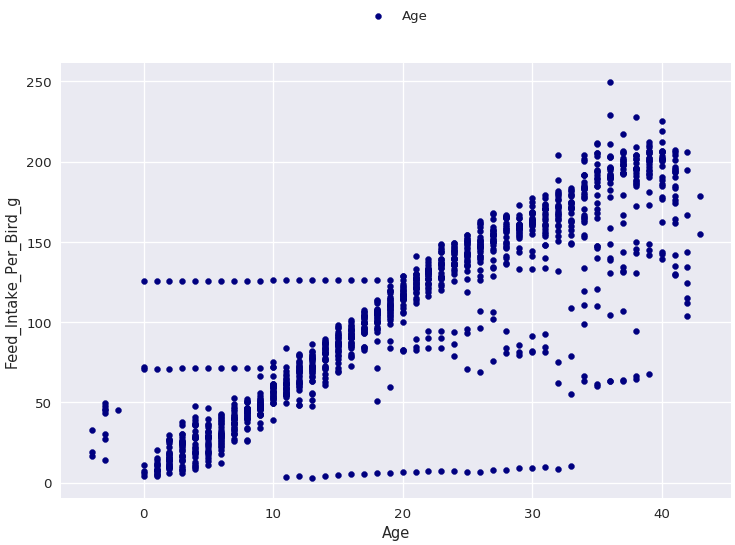

In [50]:
display(feed_A) # and also for feed_B and feed_C


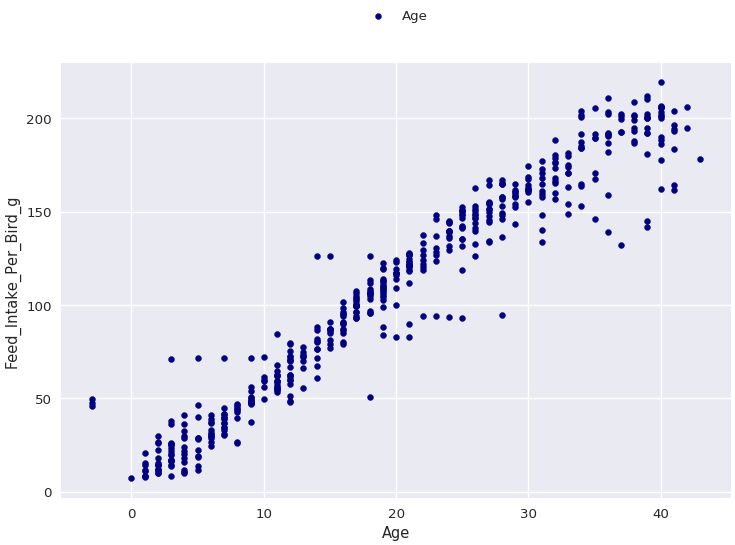

In [35]:
# Gene line A
# run 1

fAC, fAI, fAE, fAP = run(feed_A, ['Age'], 'Feed_Intake_Per_Bird_g', feed_A.Feed_Intake_Per_Bird_g)

fAP_filtered = dropExtreme(fAP, 50)

# run 2

fAC2, fAI2, fAE2, fAP2 = run(fAP_filtered, ['Age'], 'Feed_Intake_Per_Bird_g', fAP_filtered.Feed_Intake_Per_Bird_g, False)

display(fAP2)


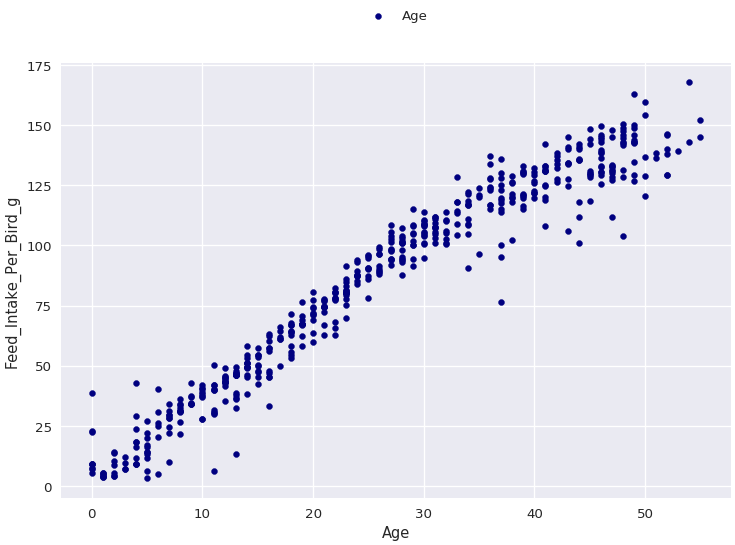

In [36]:
# Gene line B
# run 1

fBC, fBI, fBE, fBP = run(feed_B, ['Age'], 'Feed_Intake_Per_Bird_g', feed_B.Feed_Intake_Per_Bird_g)

fBP_filtered = dropExtreme(fBP, 50)

# run 2

fBC2, fBI2, fBE2, fBP2 = run(fBP_filtered, ['Age'], 'Feed_Intake_Per_Bird_g', fBP_filtered.Feed_Intake_Per_Bird_g, False)

display(fBP2)


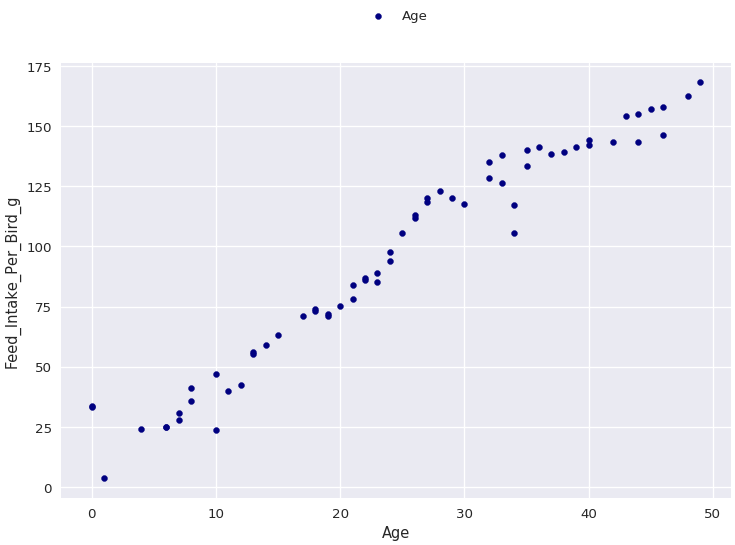

In [39]:
# Gene line C
# run 1

fCC, fCI, fCE, fCP = run(feed_C, ['Age'], 'Feed_Intake_Per_Bird_g', feed_C.Feed_Intake_Per_Bird_g)

fCP_filtered = dropExtreme(fCP, 50)

# run 2

fCC2, fCI2, fCE2, fCP2 = run(fCP_filtered, ['Age'], 'Feed_Intake_Per_Bird_g', fCP_filtered.Feed_Intake_Per_Bird_g, False)

display(fCP2)

## Age vs. Water

### draw graphs to determine value used in dropExtreme()


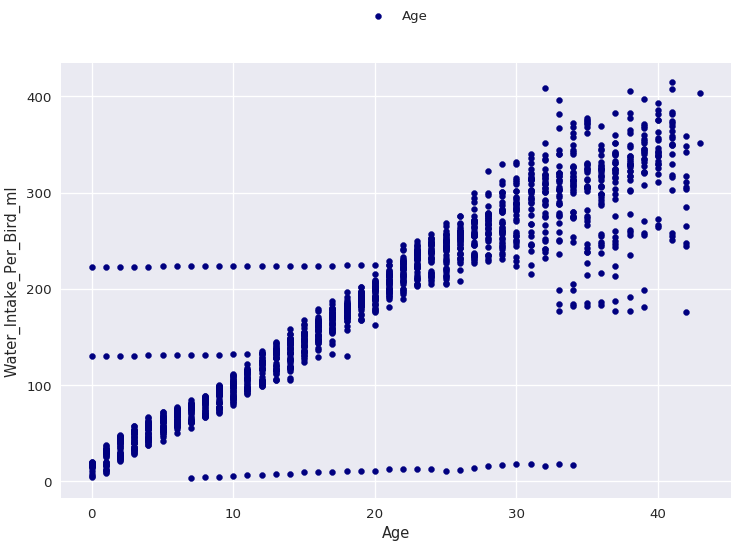

In [55]:
display(water_A) # and also for water_B and water_C


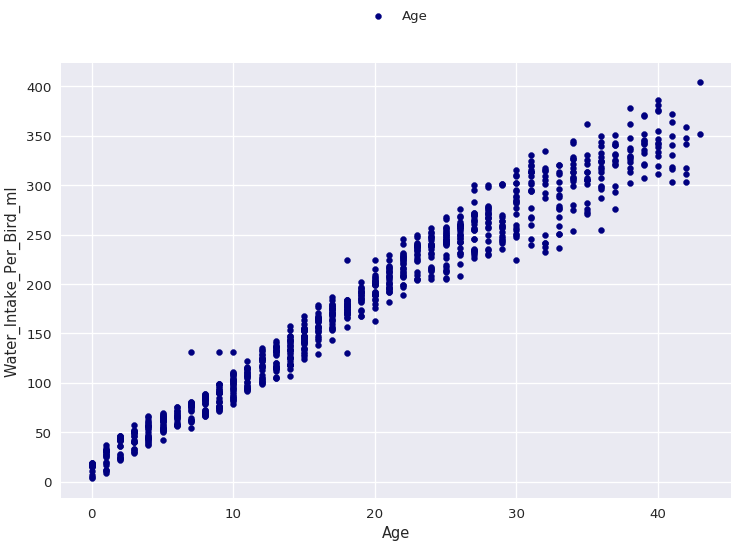

In [57]:
# Gene line A
# run 1

wAC, wAI, wAE, wAP = run(water_A, ['Age'], 'Water_Intake_Per_Bird_ml', water_A.Water_Intake_Per_Bird_ml)

wAP_filtered = dropExtreme(wAP, 60)

# run 2

wAC2, wAI2, wAE2, wAP2 = run(wAP_filtered, ['Age'], 'Water_Intake_Per_Bird_ml', wAP_filtered.Water_Intake_Per_Bird_ml, False)

display(wAP2)


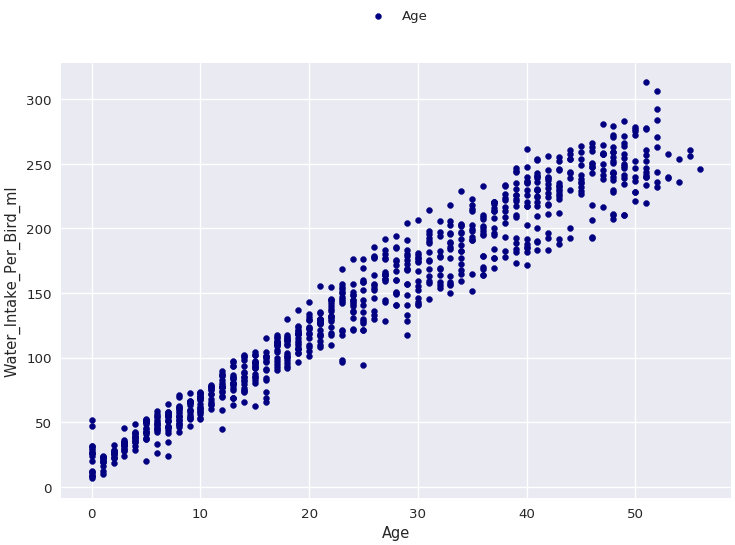

In [47]:
# Gene line B
# run 1

wBC, wBI, wBE, wBP = run(water_B, ['Age'], 'Water_Intake_Per_Bird_ml', water_B.Water_Intake_Per_Bird_ml)

wBP_filtered = dropExtreme(wBP, 60)

# run 2

wBC2, wBI2, wBE2, wBP2 = run(wBP_filtered, ['Age'], 'Water_Intake_Per_Bird_ml', wBP_filtered.Water_Intake_Per_Bird_ml, False)

display(wBP2)


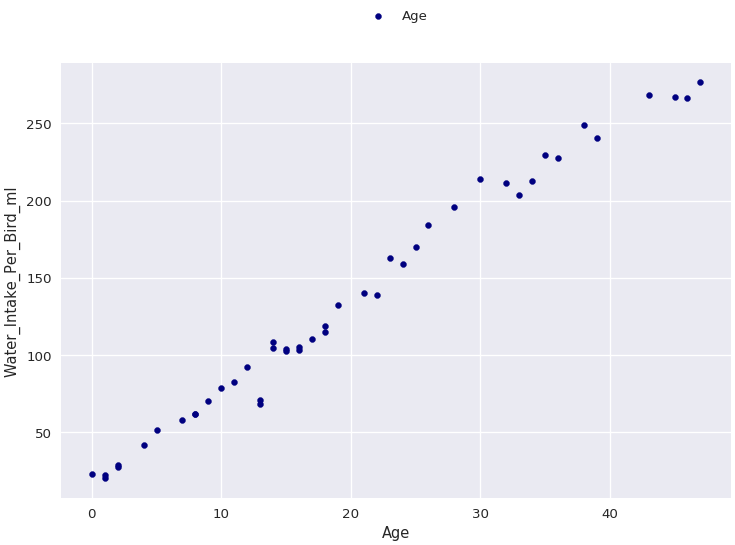

In [56]:
# Gene line C
# run 1

wCC, wCI, wCE, wCP = run(water_C, ['Age'], 'Water_Intake_Per_Bird_ml', water_C.Water_Intake_Per_Bird_ml)

wCP_filtered = dropExtreme(wCP, 60)

# run 2

wCC2, wCI2, wCE2, wCP2 = run(wCP_filtered, ['Age'], 'Water_Intake_Per_Bird_ml', wCP_filtered.Water_Intake_Per_Bird_ml, False)

display(wCP2)

## Age vs. Weight

### draw graphs to determine value used in dropExtreme()
It seems that data is pretty good and don't need to run LR twice

In [ ]:
display(Weight_A) # also for B and C

In [ ]:
# Gene line A
# run 1

wtAC, wtAI, wtAE, wtAP = run(weight_A, ['Age'], 'Body_Weight_g', weight_A.Body_Weight_g)

display(wtAP)

In [ ]:
# Gene line B
# run 1

wtBC, wtBI, wtBE, wtBP = run(weight_B, ['Age'], 'Body_Weight_g', weight_B.Body_Weight_g)

display(wtBP)

In [ ]:
# Gene line A
# run 1

wtCC, wtCI, wtCE, wtCP = run(weight_C, ['Age'], 'Body_Weight_g', weight_C.Body_Weight_g)

display(wtCP)